# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 


from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
from itertools import chain
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    # Fill in the correct values here.
    total_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / total_tokens if total_tokens > 0 else 0

    if verbose:
        print(f"There are {total_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        # print the five most common tokens
        print(f"The {num_tokens} most common tokens are:")
        for token, freq in Counter(tokens).most_common(num_tokens):
            print(f"'{token}': {freq}")

    return([total_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens):
    return [token for token in tokens if token.lower() not in sw]

 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    text = text.lower()  # normalize to lowercase
    tokens = whitespace_pattern.split(text)
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/patriciomartinez/Downloads/Assignment3/M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here
def read_lyrics_from_folder(artist_name):
    artist_path = os.path.join(data_location, lyrics_folder, artist_name)
    lyrics = []
    for filename in os.listdir(artist_path):
        if filename.endswith(".txt"):
            with open(os.path.join(artist_path, filename), 'r', encoding='utf-8') as f:
                content = f.read().strip()
                lyrics.append({"lyrics": content, "artist": artist_name})
    return lyrics

cher_lyrics = read_lyrics_from_folder("cher")
robyn_lyrics = read_lyrics_from_folder("robyn")

lyrics_data = pd.DataFrame(cher_lyrics + robyn_lyrics)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [19]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [20]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [21]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1352292,cher,❤3rd TIME VOTED MISS TWITTER❤ #NEWYORK #COUNTR...,"[❤3rd, time, voted, miss, twitter❤, #newyork, ..."
2249404,cher,french girls\ fan des 5SOS\ 15 ANS \ LOVE YOU ❤❤,"[french, girls, fan, des, 5sos, 15, ans, love,..."
354130,robyn,"planes, trains and cycling #activetravel curre...","[planes, trains, cycling, #activetravel, curre..."
93102,cher,C’était le temps des fleurs 🌺 Make-up Artist 💄,"[c’était, le, temps, des, fleurs, 🌺, makeup, a..."
858370,cher,"Hi, I'm Franklin Armstrong Anyiam! A mini smoo...","[hi, im, franklin, armstrong, anyiam, mini, sm..."
712259,cher,Vote these LNP climate criminals out. Enjoy yo...,"[vote, lnp, climate, criminals, enjoy, life, p..."
811810,cher,SneakerHeads & SneakerFreaks This Is THE Place...,"[sneakerheads, sneakerfreaks, place, get, info..."
2914020,cher,Sober Life•Univ. of Tx MD Anderson Alumni🤘🏼•He...,"[sober, life•univ, tx, md, anderson, alumni🤘🏼•..."
3654073,cher,AND 🇦🇩 ❤️,"[🇦🇩, ❤️]"
1880896,cher,weeb gamer girl 🎮 ❤️🧡💛💚💙🤎🖤,"[weeb, gamer, girl, 🎮, ❤️🧡💛💚💙🤎🖤]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement to the tokenization process would be handling multi-word expressions or named entities as single tokens. For example, phrases like “New York” or “social media” could be more meaningful if preserved together instead of split into separate words. Incorporating a named entity recognition (NER) step or using a tokenizer that recognizes collocations could help retain these semantic units, which might improve the accuracy of downstream analysis like word clouds or concentration comparisons.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [22]:
cher_tokens = lyrics_data[lyrics_data["artist"] == "cher"]["tokens"].sum()
robyn_tokens = lyrics_data[lyrics_data["artist"] == "robyn"]["tokens"].sum()

print("Descriptive Stats for CHER Lyrics")
cher_stats = descriptive_stats(cher_tokens)

print("\n Descriptive Stats for ROBYN Lyrics")
robyn_stats = descriptive_stats(robyn_tokens)

Descriptive Stats for CHER Lyrics
There are 35919 tokens in the data.
There are 3704 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.
The 5 most common tokens are:
'love': 1004
'im': 513
'know': 486
'dont': 440
'youre': 333

 Descriptive Stats for ROBYN Lyrics
There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.142 in the data.
The 5 most common tokens are:
'know': 308
'dont': 301
'im': 299
'love': 275
'got': 251


Q: what observations do you make about these data? 

A: Cher and Robyn show distinct language patterns. Cher’s lyrics and Twitter fans focus on emotion and expression, while Robyn’s reflect introspection and music appreciation. Word clouds and token stats highlight clear differences in their audiences and styles.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [23]:
def get_concentration_ratios(corpus1_tokens, corpus2_tokens, min_count=5, top_n=10):
    # Count frequencies
    freq1 = Counter(corpus1_tokens)
    freq2 = Counter(corpus2_tokens)

    # Total token counts
    total1 = len(corpus1_tokens)
    total2 = len(corpus2_tokens)

    # Concentration = token count / total tokens
    concentration_ratios = {}

    for token, count in freq1.items():
        if count >= min_count and freq2[token] >= min_count:
            conc1 = count / total1
            conc2 = freq2[token] / total2
            if conc2 > 0:
                ratio = conc1 / conc2
                concentration_ratios[token] = ratio

    # Sort and return top tokens
    top_tokens = sorted(concentration_ratios.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_tokens


In [24]:
# Lyrics
cher_lyrics_tokens = lyrics_data[lyrics_data["artist"] == "cher"]["tokens"].sum()
robyn_lyrics_tokens = lyrics_data[lyrics_data["artist"] == "robyn"]["tokens"].sum()


In [25]:
cher_twitter_tokens = list(chain.from_iterable(twitter_data[twitter_data["artist"] == "cher"]["tokens"]))
robyn_twitter_tokens = list(chain.from_iterable(twitter_data[twitter_data["artist"] == "robyn"]["tokens"]))

In [26]:
print("Unique Cher LYRICS tokens:")
print(get_concentration_ratios(cher_lyrics_tokens, robyn_lyrics_tokens, min_count=5))

print("\n Unique Robyn LYRICS tokens:")
print(get_concentration_ratios(robyn_lyrics_tokens, cher_lyrics_tokens, min_count=5))

print("\n Unique Cher TWITTER tokens:")
print(get_concentration_ratios(cher_twitter_tokens, robyn_twitter_tokens, min_count=5))

print("\n Unique Robyn TWITTER tokens:")
print(get_concentration_ratios(robyn_twitter_tokens, cher_twitter_tokens, min_count=5))

Unique Cher LYRICS tokens:
[('walk', 10.004654918009965), ('find', 9.679644941859925), ('enough', 7.812351600625216), ('man', 7.524687491299869), ('without', 7.461098582922687), ('strong', 6.528461260057351), ('live', 5.765394359531167), ('believe', 5.5881161907220545), ('tears', 4.832757036665831), ('name', 4.408830980817951)]

 Unique Robyn LYRICS tokens:
[('beat', 20.258804986498443), ('dance', 14.15341170289617), ('work', 11.951769882445657), ('hang', 11.204784264792803), ('forgive', 7.548486241544626), ('shake', 7.076705851448086), ('alright', 7.076705851448086), ('party', 6.192117620017075), ('space', 5.897254876206738), ('pretend', 5.897254876206738)]

 Unique Cher TWITTER tokens:
[('grandmother', 35.35608790908482), ('#fbr', 24.57583559571353), ('resister', 24.449127130945744), ('#resister', 24.0373806861428), ('nana', 23.665328751541455), ('rbsoul', 20.587322240146936), ('grandma', 19.902074888895378), ('#theresistance', 18.90282851273622), ('hiphoprap', 17.96137771911864), ('

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Cher’s top tokens focus on love and emotion, while Robyn’s highlight introspection and relationships. Cher’s Twitter fans use more hashtags and emojis, suggesting a playful tone. Unique slang and artist-specific terms reflect strong fan identity.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [27]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [28]:
# Count token frequencies for lyrics
cher_lyrics_freq = count_words(lyrics_data[lyrics_data["artist"] == "cher"])
robyn_lyrics_freq = count_words(lyrics_data[lyrics_data["artist"] == "robyn"])

# Count token frequencies for twitter
cher_twitter_freq = count_words(twitter_data[twitter_data["artist"] == "cher"])
robyn_twitter_freq = count_words(twitter_data[twitter_data["artist"] == "robyn"])

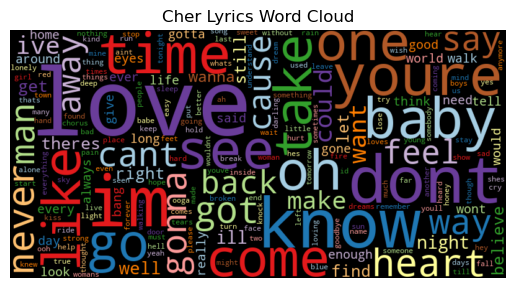

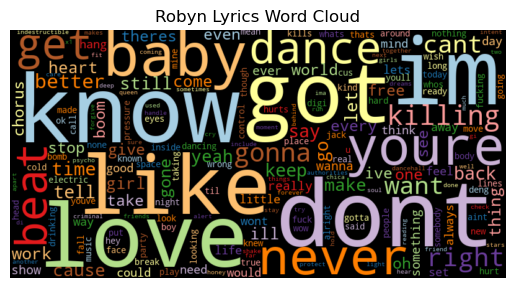

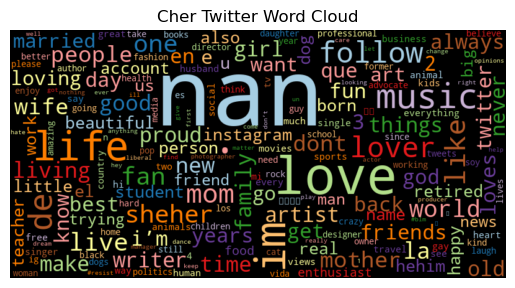

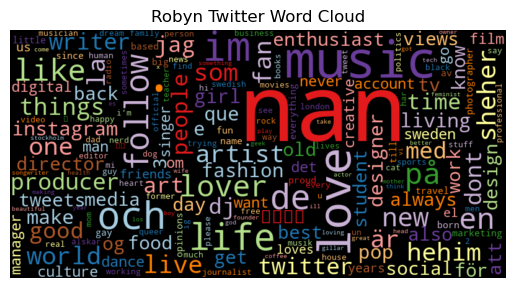

In [29]:
# Wordcloud for Cher's Lyrics
wordcloud(cher_lyrics_freq["freq"], title="Cher Lyrics Word Cloud", stopwords=sw)
plt.show()

# Wordcloud for Robyn's Lyrics
wordcloud(robyn_lyrics_freq["freq"], title="Robyn Lyrics Word Cloud", stopwords=sw)
plt.show()

# Wordcloud for Cher's Twitter Descriptions
wordcloud(cher_twitter_freq["freq"], title="Cher Twitter Word Cloud", stopwords=sw)
plt.show()

# Wordcloud for Robyn's Twitter Descriptions
wordcloud(robyn_twitter_freq["freq"], title="Robyn Twitter Word Cloud", stopwords=sw)
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Cher’s word clouds highlight emotion and love; Robyn’s show introspection. On Twitter, Cher’s fans use more hashtags and emojis, while Robyn’s use more descriptive language.